In [2213]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [2214]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_100_1_1e-1_wgan' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_100_1_1e-1_wgan_reals.npy']

In [2215]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [2216]:
reals.shape

(100, 1, 32, 32)

In [2217]:
reals.mean(1).shape

(100, 32, 32)

# Error of ASPA $i$

In [2218]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.0000,1.00000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.00000
mean,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723
25%,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723
50%,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723
75%,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723
max,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723


In [2219]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-1.169401,-3.503879,-7.9954,-5.74687,3.459722e+27,5.675549e+07,1274.315834,-0.203806,9.53723


In [2220]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [2221]:
reals.shape

(100, 1, 32, 32)

In [2222]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(100, 1, 32, 32)

In [2223]:
reals.shape

(100, 1, 32, 32)

## Spectrum plot

In [2224]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [2225]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

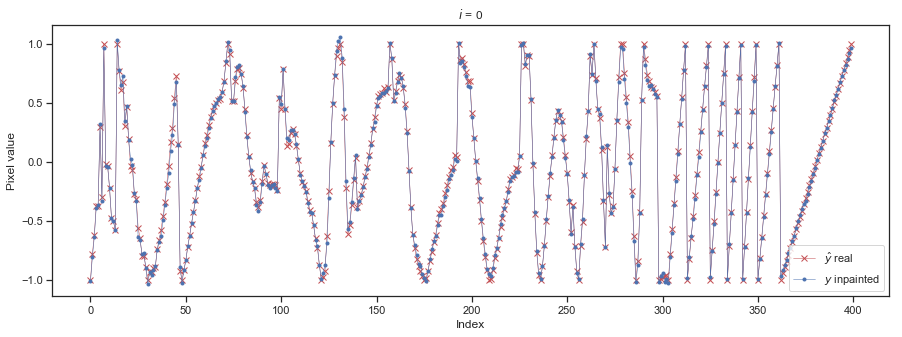

In [2226]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

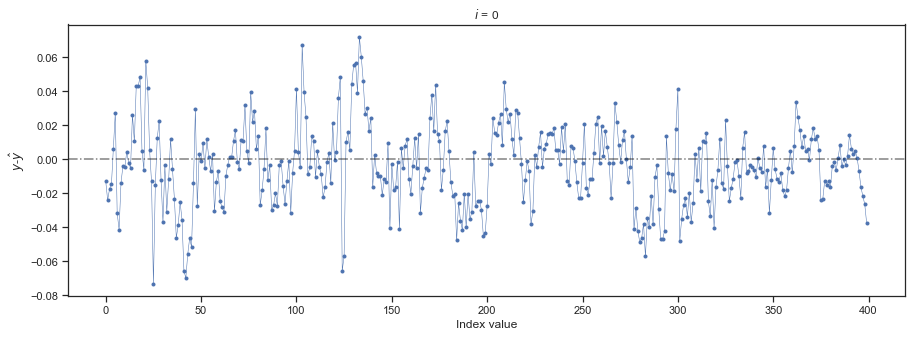

In [2227]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:370: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:371: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


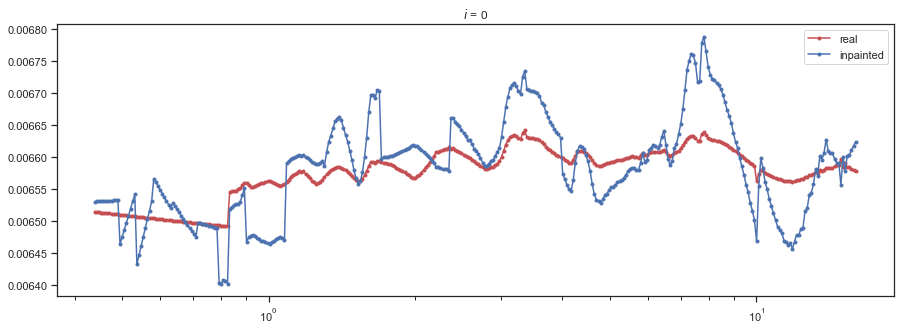

In [2228]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

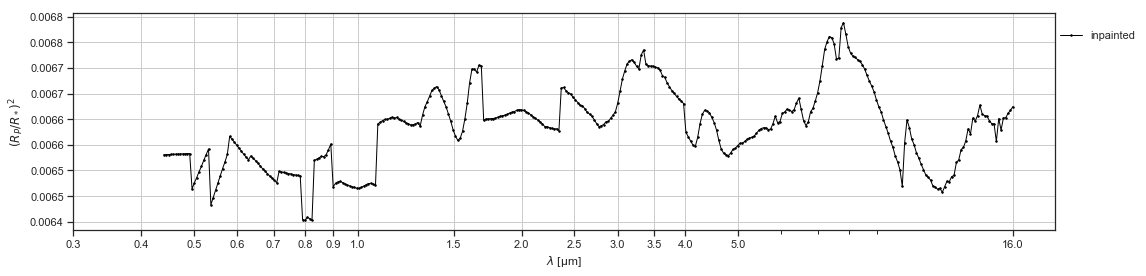

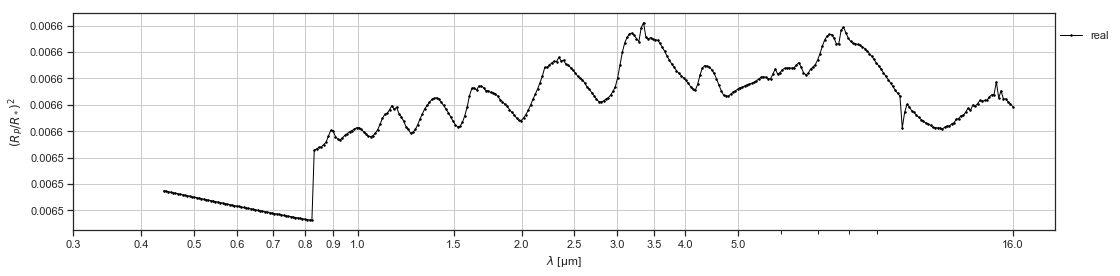

In [2229]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [2230]:
reals.shape

(100, 1, 32, 32)

In [2231]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [2232]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [2233]:
contextuals.shape

(100,)

In [2234]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [2235]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-0.026708,-2.226745,0.038228,-1.973321,6.058002,0.927664,-5.469384
std,12.403945,10.544629,56.061920,11.634685,33.201487,1.126310,31.915010
min,-62.996940,-55.652563,-80.635616,-68.514476,-53.121578,-1.498870,-49.209405
25%,-1.295113,-4.159286,-28.044267,-3.310453,-15.437405,0.191442,-27.702006
50%,0.182392,-0.948409,-4.399992,-0.820882,1.790532,0.844418,-11.554143
75%,1.989161,1.820104,11.684926,2.418659,22.160219,1.594426,5.692099
max,38.048163,31.631728,217.872082,35.303619,125.573784,3.799411,94.265857


In [2236]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,16.940057,5.116367,212.863498,-10.824435,13.926558,1.478109,4.262206
1,-62.996940,-43.192435,84.524654,-68.514476,21.996367,-0.122486,45.022065
2,-0.376191,-0.734005,-13.125974,-0.868831,-27.408697,1.396764,-10.762144
3,0.992142,15.494785,177.660263,4.609970,-53.121578,1.426232,4.932958
4,0.332075,-7.384940,-61.797206,-2.132811,-24.642201,0.814057,-16.528470
5,1.815862,-10.935792,40.235565,-1.543176,22.219885,0.160657,-25.786772
6,5.476938,2.807911,-4.313115,-2.003783,-21.542451,-0.159401,-35.013057
7,1.573577,-2.599538,-1.054915,19.532671,31.851624,-1.114648,-8.070248
8,-3.566568,-0.468190,-27.953509,-0.292968,-17.677535,-0.526763,-26.436354
9,-0.776994,6.171778,11.646720,-1.962119,-1.360461,0.290953,-3.788744


In [2237]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
58,1.101378,0.558948,0.007117,0.606357,7.727841,0.088515,7.969521


In [2238]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [2239]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,-4.608889,-4.523333,-4.577778,-5.005556,2.654669e+27,8.083265e+07,1508.888889,-4.595179,-4.436111,-4.212966,...,1356.503697,-0.026708,-2.226745,0.038228,-1.973321,6.058002,0.927664,-5.469384,-0.208029,10.737640
std,2.242582,2.239679,2.129315,2.263884,6.819912e+26,1.563348e+07,322.564551,2.304164,2.253317,2.496688,...,309.889330,12.403945,10.544629,56.061920,11.634685,33.201487,1.126310,31.915010,0.025534,4.393572
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-8.247929,-8.224258,-8.123397,...,948.593378,-62.996940,-55.652563,-80.635616,-68.514476,-53.121578,-1.498870,-49.209405,-0.277642,7.449029
25%,-6.444445,-6.444445,-6.444445,-7.222222,2.277600e+27,6.680384e+07,1222.222209,-6.515701,-6.311977,-6.859293,...,1061.643608,-1.295113,-4.159286,-28.044267,-3.310453,-15.437405,0.191442,-27.702006,-0.227032,8.722910
50%,-4.888889,-4.888889,-4.500000,-5.666667,2.783733e+27,7.767889e+07,1555.555556,-4.862531,-4.599885,-3.750405,...,1280.888997,0.182392,-0.948409,-4.399992,-0.820882,1.790532,0.844418,-11.554143,-0.207973,9.564431
75%,-2.555555,-2.555555,-2.555555,-3.333333,3.100067e+27,9.399146e+07,1777.777791,-2.064214,-2.571559,-1.901325,...,1649.358280,1.989161,1.820104,11.684926,2.418659,22.160219,1.594426,5.692099,-0.190192,11.615986
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-1.003321,-0.788399,-1.021860,...,1951.924682,38.048163,31.631728,217.872082,35.303619,125.573784,3.799411,94.265857,-0.147013,47.728336


In [2240]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-1.000000,-3.333333,-2.555555,-6.444445,3.036800e+27,5.592880e+07,1222.222209,-1.169401,-3.503879,-7.995400,...,1274.315834,16.940057,5.116367,212.863498,-10.824435,13.926558,1.478109,4.262206,-0.203806,9.537230
1,-3.333333,-4.888889,-4.111111,-2.555555,2.530667e+27,9.942898e+07,1000.000000,-1.233435,-2.777259,-7.586014,...,1450.220648,-62.996940,-43.192435,84.524654,-68.514476,21.996367,-0.122486,45.022065,-0.190441,47.728336
2,-7.222222,-5.666667,-1.777778,-5.666667,2.783733e+27,7.224137e+07,1444.444444,-7.195053,-5.625073,-1.544427,...,1288.991258,-0.376191,-0.734005,-13.125974,-0.868831,-27.408697,1.396764,-10.762144,-0.188649,11.911581
3,-4.111111,-1.000000,-2.555555,-4.111111,3.542933e+27,6.680384e+07,1333.333328,-4.151899,-1.154948,-7.095762,...,1399.106100,0.992142,15.494785,177.660263,4.609970,-53.121578,1.426232,4.932958,-0.203994,13.298110
4,-1.000000,-4.111111,-3.333333,-2.555555,2.277600e+27,7.767889e+07,2000.000000,-1.003321,-3.807508,-1.273426,...,1669.430599,0.332075,-7.384940,-61.797206,-2.132811,-24.642201,0.814057,-16.528470,-0.211254,8.711811
5,-5.666667,-8.000000,-4.888889,-1.000000,2.783733e+27,1.048665e+08,1333.333328,-5.769566,-7.125137,-6.855961,...,989.509702,1.815862,-10.935792,40.235565,-1.543176,22.219885,0.160657,-25.786772,-0.186040,8.396015
6,-6.444445,-2.555555,-8.000000,-3.333333,2.783733e+27,1.048665e+08,1555.555556,-6.797403,-2.627313,-7.654951,...,1010.908008,5.476938,2.807911,-4.313115,-2.003783,-21.542451,-0.159401,-35.013057,-0.176473,8.645297
7,-4.111111,-5.666667,-7.222222,-6.444445,2.277600e+27,1.048665e+08,1555.555556,-4.175803,-5.519360,-7.146034,...,1430.018365,1.573577,-2.599538,-1.054915,19.532671,31.851624,-1.114648,-8.070248,-0.197417,9.024614
8,-3.333333,-4.111111,-1.777778,-1.777778,2.783733e+27,6.136632e+07,2000.000000,-3.214448,-4.091863,-1.280826,...,1471.272929,-3.566568,-0.468190,-27.953509,-0.292968,-17.677535,-0.526763,-26.436354,-0.232718,10.239104
9,-4.111111,-4.888889,-7.222222,-1.000000,2.277600e+27,6.136632e+07,2000.000000,-4.079168,-5.190620,-8.063374,...,1924.225122,-0.776994,6.171778,11.646720,-1.962119,-1.360461,0.290953,-3.788744,-0.231346,8.683819


In [2241]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

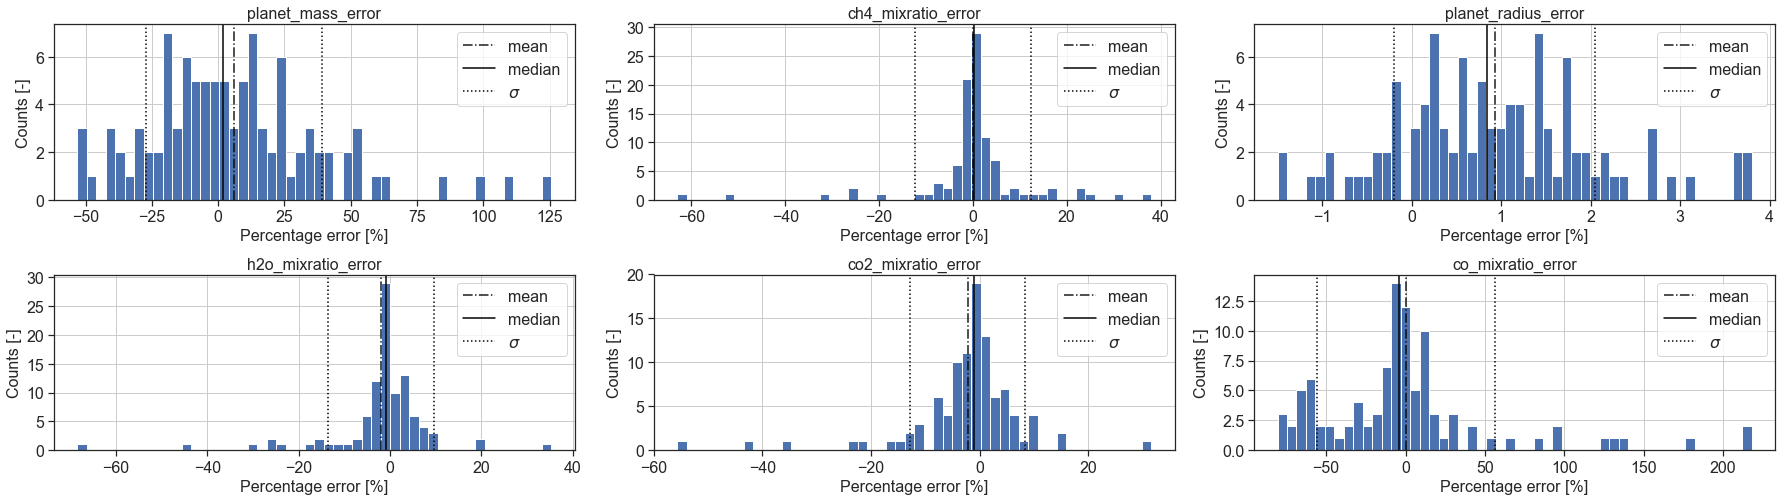

In [2242]:
#params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

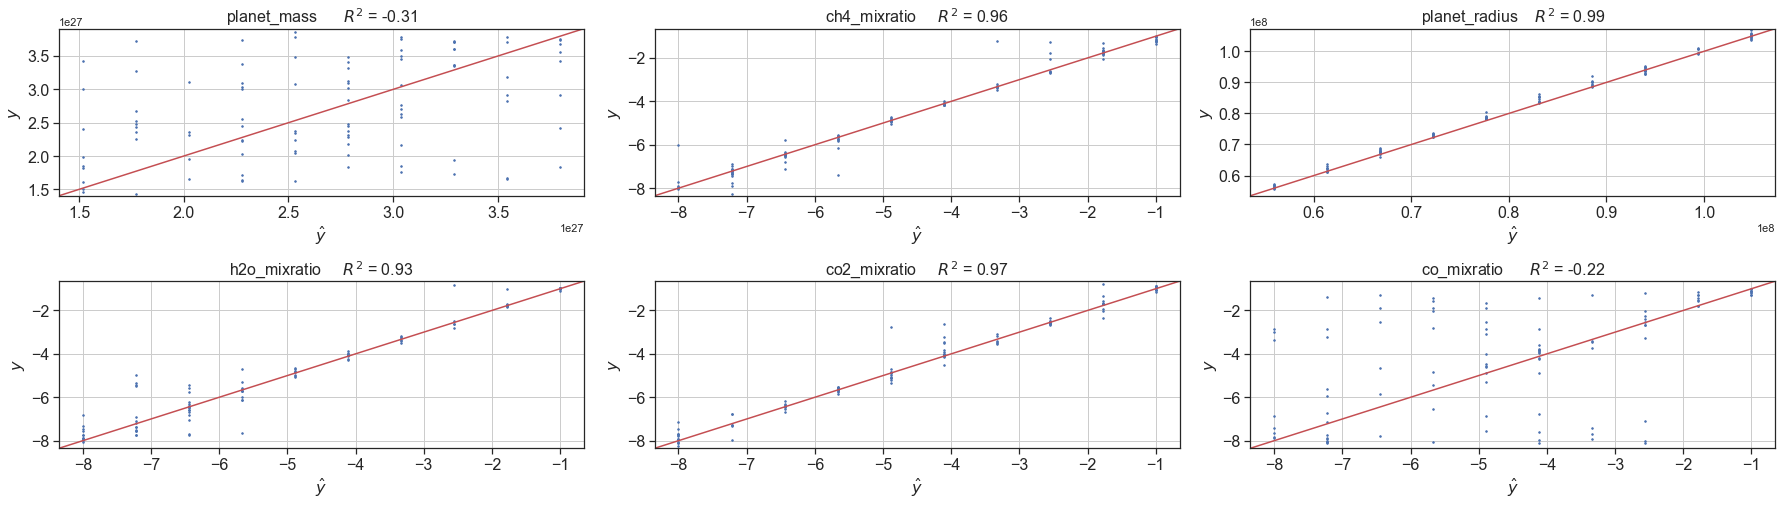

In [2243]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

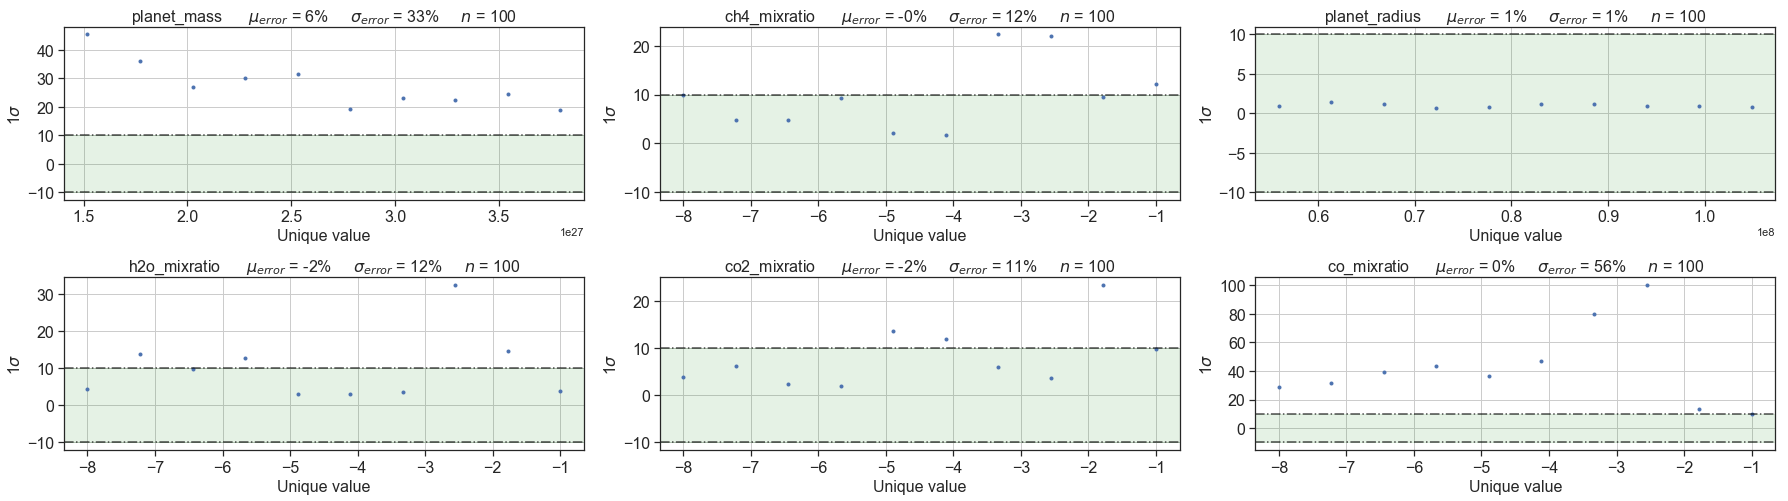

In [2244]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [2245]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [2246]:
uniques

array([-2.55555546, -4.11111111, -1.77777773, -3.3333333 , -4.88888889,
       -8.        , -7.22222227, -5.6666667 , -1.        , -6.44444454])

# Losses

In [2247]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,100.000000,100.000000
mean,-0.208029,10.737640
std,0.025534,4.393572
min,-0.277642,7.449029
25%,-0.227032,8.722910
50%,-0.207973,9.564431
75%,-0.190192,11.615986
max,-0.147013,47.728336


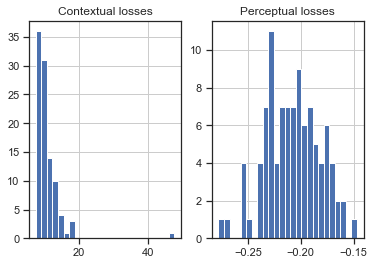

In [2248]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

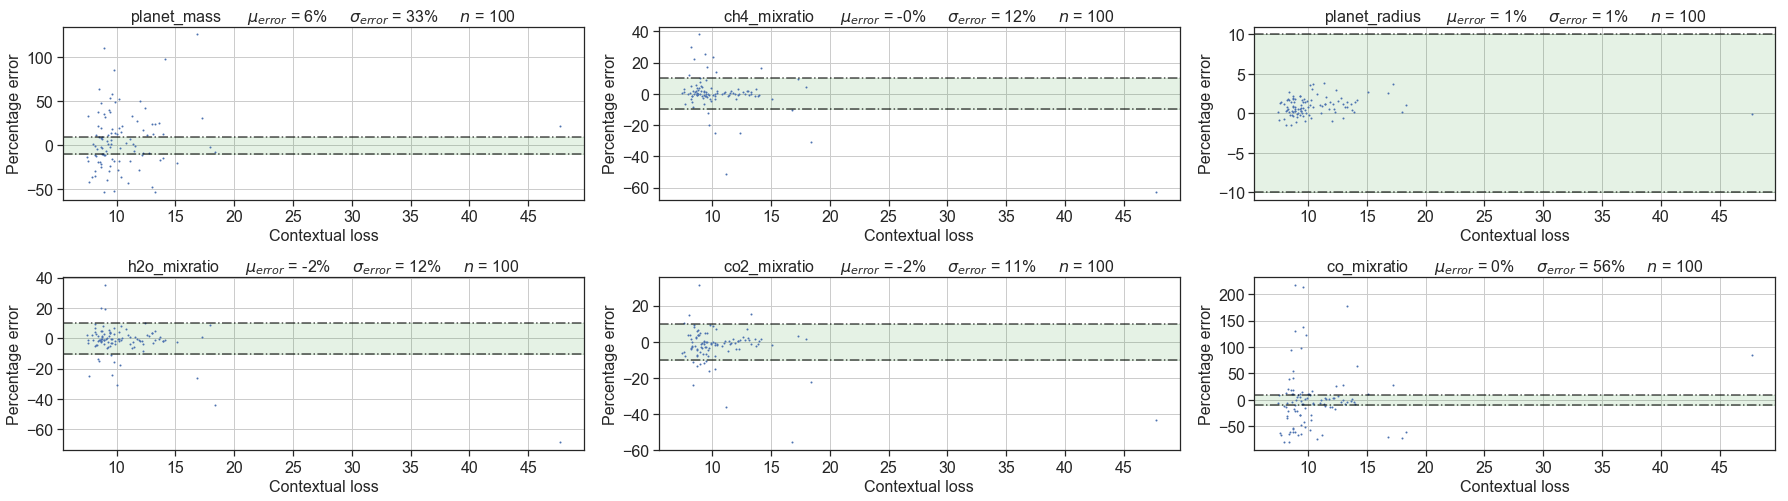

In [2249]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

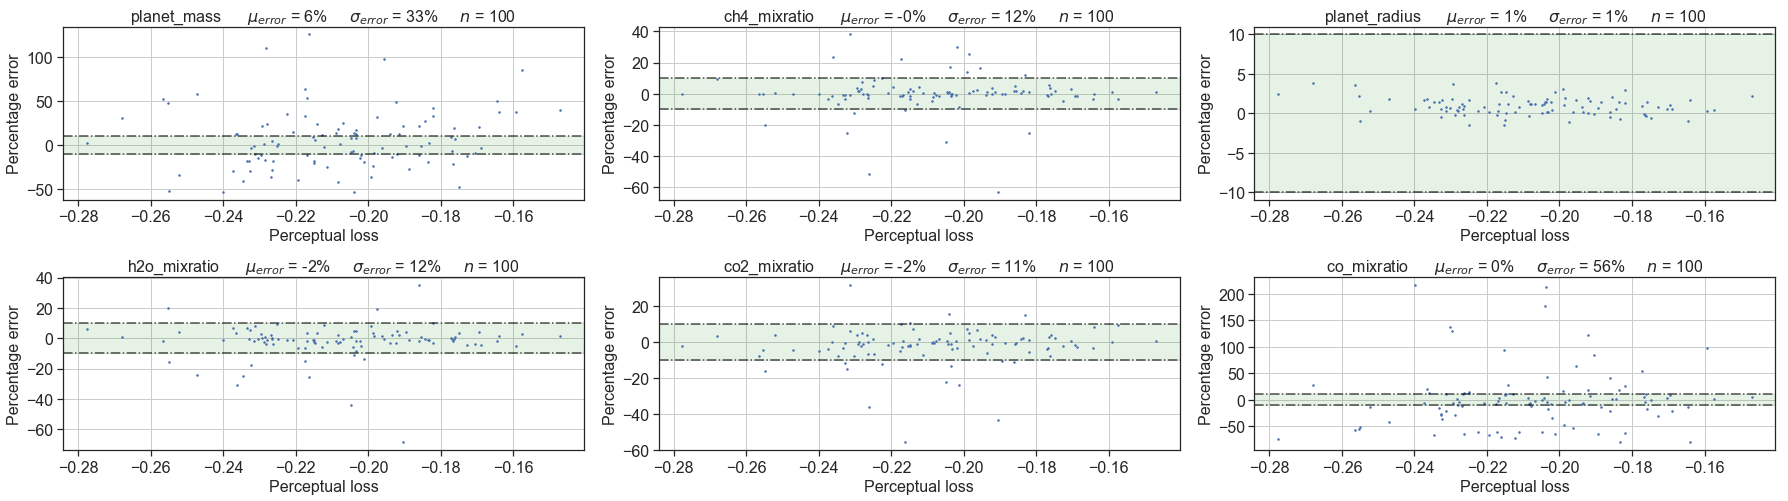

In [2250]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()